In [136]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from src import GeometricFiguresDataset, GeometricFiguresDatasetBlackWhite
from src import visualise_dataset
from src import VAE_train, VAE_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


# Data generation

Geometrical figures of random position, shape and color

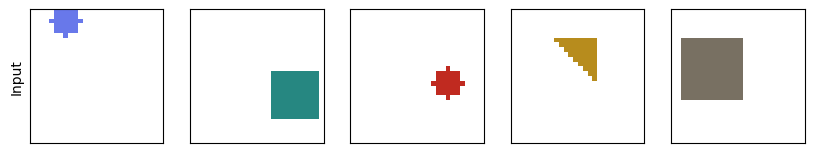

In [137]:
batch_size = 128

dataset = GeometricFiguresDataset(random_color=True, num_samples=20000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


visualise_dataset(dataloader=dataloader, device=device)



----

# Variational Autoencoder

In [138]:
class VAE_encoder(nn.Module):

    def __init__(self, image_channels = 3):
        super(VAE_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten() # 64*3*3 = 576 #calc sizes using https://madebyollin.github.io/convnet-calculator/
        )
    
    def forward(self, x):
        h = self.encoder(x)
        return h
    

class VAE_decoder(nn.Module):
    def __init__(self, image_channels = 3):
        super(VAE_decoder, self).__init__()

        self.unflatten = nn.Unflatten(1, [64, 3, 3])
        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        z = self.decoder(z)
        return z

class VAE(nn.Module):
    def __init__(self, image_channels = 3, hidden_dim = 576, latent_dim = 64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = VAE_encoder(image_channels)
        self.decoder = VAE_decoder(image_channels)
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, hidden_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        hidden = self.fc_decoder(z)
        x_recon = self.decoder(hidden)
        return x_recon
      
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, log_var


class AE(nn.Module): #autoencoder without the reparametrization, cannot sample meaningful latent space
    def __init__(self, image_channels = 3, hidden_dim = 576):
        super(AE, self).__init__()
        self.encoder = VAE_encoder(image_channels)
        self.decoder = VAE_decoder(image_channels)
        
        self.fc_decoder = nn.Linear(hidden_dim, hidden_dim)

    def decode(self, z):
        hidden = self.fc_decoder(z)
        x_recon = self.decoder(hidden)
        return x_recon
      
    def encode(self, x):
        h = self.encoder(x)
        return h

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon



vae = VAE()

rand_inp = torch.randn(8, 3, 28, 28)
vae_out, mu, log_var = vae(rand_inp)

print(rand_inp.shape, vae_out.shape, mu.shape, log_var.shape)
assert vae_out.shape == rand_inp.shape, f"Expected: {rand_inp.shape}, Got: {vae_out.shape}"


vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
criterion = VAE_loss


torch.Size([8, 3, 28, 28]) torch.Size([8, 3, 28, 28]) torch.Size([8, 64]) torch.Size([8, 64])


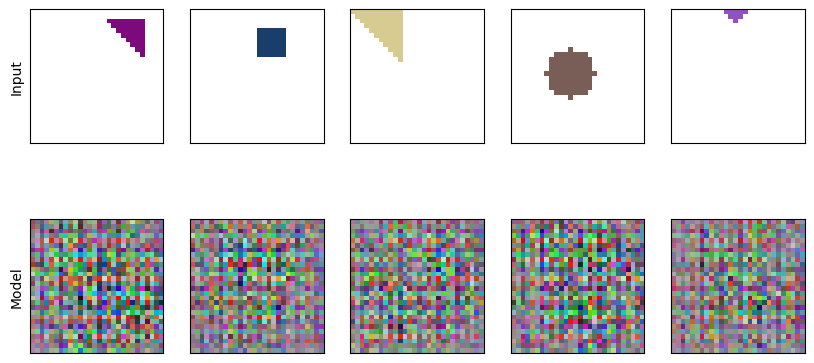

In [139]:
visualise_dataset(dataloader, vae, device)

In [140]:
VAE_train(vae, dataloader, criterion, optimizer,
          epochs=10, KL_weight = 1.0,
          device = device)

Epoch [1/10], Loss: 194481.96730, KL: 192229.23828, Recon: 2252.72954
Epoch [2/10], Loss: 171270.16244, KL: 169279.90024, Recon: 1990.26177
Epoch [3/10], Loss: 154410.91541, KL: 152499.21320, Recon: 1911.70255
Epoch [4/10], Loss: 138310.80564, KL: 136235.75990, Recon: 2075.04606
Epoch [5/10], Loss: 124529.14170, KL: 122446.24819, Recon: 2082.89345
Epoch [6/10], Loss: 113011.55562, KL: 110944.55630, Recon: 2066.99949
Epoch [7/10], Loss: 102910.83275, KL: 100841.63664, Recon: 2069.19608
Epoch [8/10], Loss: 94313.20640, KL: 92254.55834, Recon: 2058.64829
Epoch [9/10], Loss: 86691.82535, KL: 84587.56957, Recon: 2104.25596
Epoch [10/10], Loss: 79824.42528, KL: 77718.82138, Recon: 2105.60391


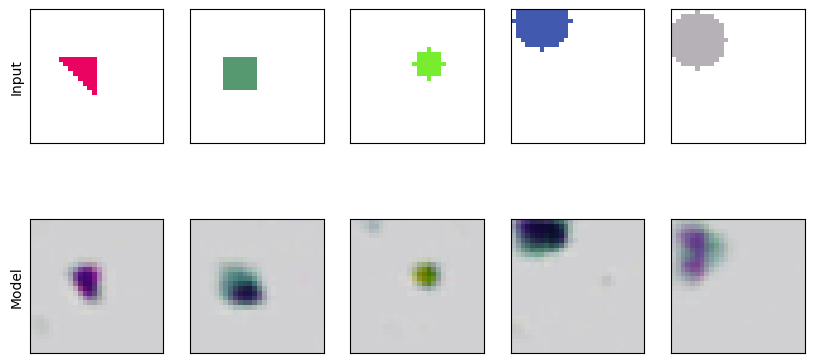

In [142]:
visualise_dataset(dataloader, vae, device)

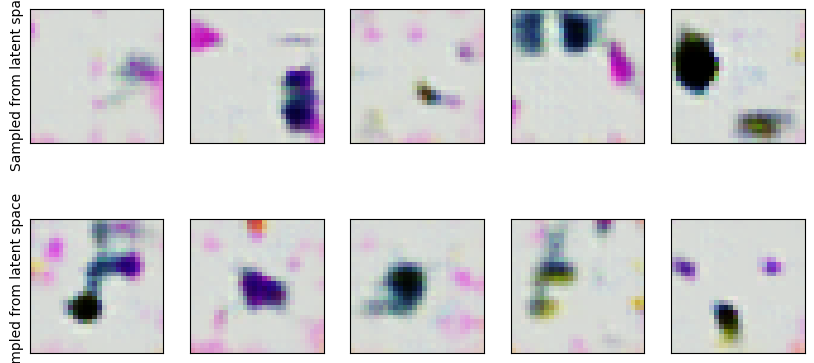

In [151]:
visualise_dataset(dataloader='latent_sample', model=vae, device=device)

# Variational Autoencoder from a github repository

Autoencoder from [link](https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb) but with adjusted architecture for my image size

In [152]:
class VAE_2(nn.Module):
    def __init__(self, image_channels=3, h_dim=256, z_dim=32):
        super(VAE_2, self).__init__()
        self.latent_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.unflatten = nn.Unflatten(1, [256, 1, 1])
        self.decoder = nn.Sequential(
            self.unflatten,
            nn.ConvTranspose2d(h_dim, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    

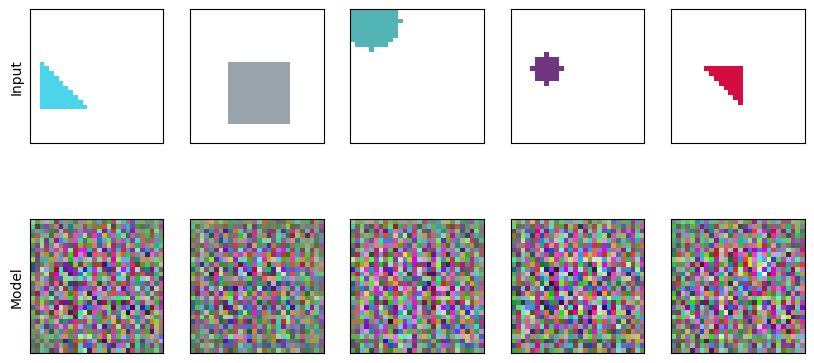

In [153]:
vae_2 = VAE_2(image_channels=3).to(device)
optimizer_2 = torch.optim.Adam(vae_2.parameters(), lr=1e-3)
criterion_2 = VAE_loss
visualise_dataset(dataloader, vae_2, device)

In [154]:
VAE_train(vae_2, dataloader, criterion_2, optimizer_2,
          epochs=10, KL_weight = 1.0,
          device = device)

Epoch [1/10], Loss: 197462.01116, KL: 196250.04180, Recon: 1211.96962
Epoch [2/10], Loss: 172104.27551, KL: 170776.77520, Recon: 1327.50063
Epoch [3/10], Loss: 154042.38095, KL: 152695.69799, Recon: 1346.68274
Epoch [4/10], Loss: 138965.54654, KL: 137625.26189, Recon: 1340.28396
Epoch [5/10], Loss: 126000.72505, KL: 124680.66652, Recon: 1320.05843
Epoch [6/10], Loss: 114657.38157, KL: 113360.96893, Recon: 1296.41270
Epoch [7/10], Loss: 104934.18521, KL: 103626.92149, Recon: 1307.26388
Epoch [8/10], Loss: 96342.07383, KL: 95008.79222, Recon: 1333.28118
Epoch [9/10], Loss: 88481.28410, KL: 87158.84620, Recon: 1322.43777
Epoch [10/10], Loss: 82093.20293, KL: 80753.88807, Recon: 1339.31459


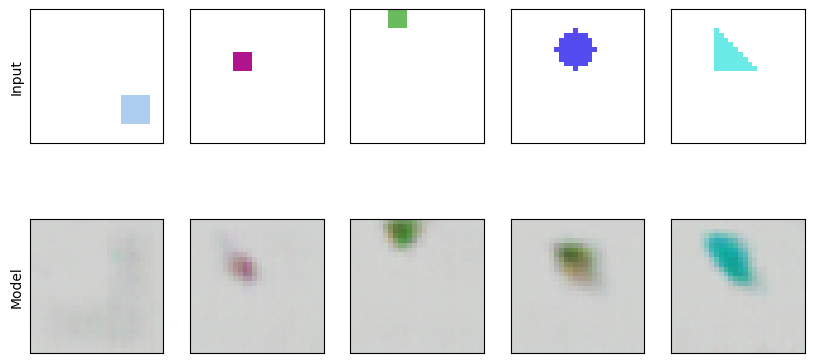

In [157]:
visualise_dataset(dataloader, vae_2, device)

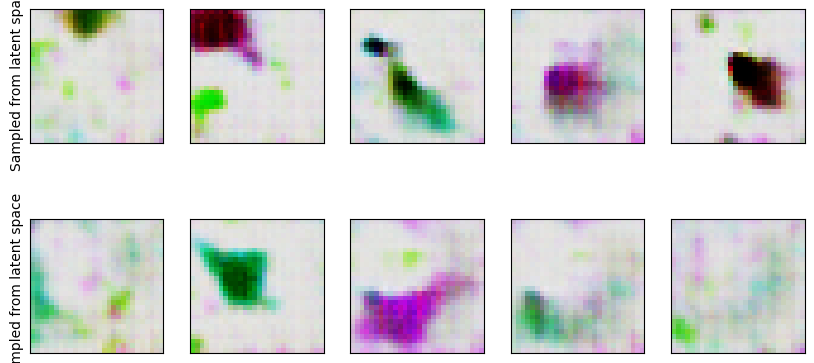

In [165]:
visualise_dataset(dataloader='latent_sample', model=vae_2, device=device)


----

# Lessons learned

## Initialise all layers with any trainable parameters in `__init__` method, not in forward method

At first try I had something like this:

```python
    def forward(self, x):
        fc = nn.Linear(784, 400)

        x = ...


        x = fc(x)

        return h
```

which lead to the fact that a new `fc` layer was created every time the forward method was called (not learning anything).
The correct way is to initialise `fc` in `__init__` method.

Activations may be called in the forward methods since they don't have any trainable parameters.


When some of my trainable parameters were initialized in the forward method, the model produced strange correlated images after 1-2 epochs. 

## Averaging of loss function over batches, pixels, etc

I used three different loss functions (see below), only one of which (`VAE_loss_correct`) correctly averages KL and reconstruction losses. 

In fact, `VAE_loss_correct` does not average over batch and pixels/latent dimenstions. The other two functions (`VAE_loss_tmp` and `VAE_loss_other_tmp`) average either KL or reconstruction loss over batch and pixels/latent dimensions, but not reconstruciton and KL losses together, which may lead to incorrect results.

Code for reproducing is below

```python
def VAE_loss_tmp(recon_x, x, mu, logvar, KL_weight = 1.0):
    BCE = F.binary_cross_entropy(recon_x, x)
    #BCE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL_weight*KLD, BCE, KLD

def VAE_loss_other_tmp(recon_x, x, mu, logvar, KL_weight = 1.0):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_weight*KLD, BCE, KLD


def VAE_loss_correct(recon_x, x, mu, logvar, KL_weight = 1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KL_weight*KLD, BCE, KLD


x_input = next(iter(dataloader))[0]
x_recon, mu, log_var = vae(x_input)

x_recon_np = x_recon.detach().cpu().numpy()
x_input_np = x_input.detach().cpu().numpy()
mu_np = mu.detach().cpu().numpy()
log_var_np = log_var.detach().cpu().numpy()
batch_size = x_input.shape[0]

l1, rec1, kl1 = VAE_loss(x_recon, x_input, mu, log_var)
l2, rec2, kl2 = VAE_loss_other(x_recon, x_input, mu, log_var)
l3, rec3, kl3 = VAE_loss_correct(x_recon, x_input, mu, log_var)

print(l1, rec1, kl1)
print(l2, rec2, kl2)
print(l3, rec3, kl3)


BCE_my = x_input_np*np.log(x_recon_np) + (1-x_input_np)*np.log(1-x_recon_np)
BCE_my = -np.sum(BCE_my)
BCE_my_avg_per_batch__pix = BCE_my/(batch_size*28*28*3)

print(BCE_my, BCE_my_avg_per_batch__pix)


KL_my = 0.5*np.sum(1 + log_var_np - mu_np**2 - np.exp(log_var_np))
KL_my_avg_per_batch_per_latent = KL_my/batch_size/mu_np.shape[1]

print(KL_my, KL_my_avg_per_batch_per_latent)

```

##  For synthetic datasets, `__len__(self)` for `torch.utils.data.Dataset` matters

It emulates the total amount of data you have in the dataset to control the number of batches in one epoch.
Even though the dataset is synthetic and every batch will be unique, the total number of samples in the dataset should be large enough to have a **reasonable number of batches** in one epoch.